<a href="https://colab.research.google.com/github/patriciamedyna/Classifier_page/blob/main/LSTM_Classifier_without_Tags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import glob
import numpy as np
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

plt.style.use('ggplot')

## Passos do pré-processamento

 - Obter os quadrantes
 - Formatar os quadrantes e obter apenas o texto correspondente
 - Criar um dataframe com os atributos `nome do arquivo txtx`, `texto`, `numero de paginas`

In [3]:
# obtem a classe (numero de paginas) do arquivo
def get_target(filepath):
    fname = filepath.split('/')[-1]
    if '_' in fname:
        return 1
        
    return 0

In [4]:
# obter todo o conteudo de texto do arquivo
def extract_content(filepath):
    data = []
    with open(filepath, 'r') as fp:
        data = fp.readlines()
            
    return data

In [5]:
replace_list = {r"i'm": 'i am',
                r"'re": ' are',
                r"let’s": 'let us',
                r"'s":  ' is',
                r"'ve": ' have',
                r"can't": 'can not',
                r"cannot": 'can not',
                r"shan’t": 'shall not',
                r"n't": ' not',
                r"'d": ' would',
                r"'ll": ' will',
                r"'scuse": 'excuse',
                ',': ' ,',
                '.': ' .',
                '!': ' !',
                '?': ' ?',
                '\s+': ' '}

In [6]:
# substituir os caracteres para melhorar o contexto
def clean_text(text):
    for s in replace_list:
        text = text.replace(s, replace_list[s])
    text = ' '.join(text.split())

    return text

In [7]:
def remove_element(lista, element):
    while element in lista: lista.remove(element)    
    return lista

In [8]:
# obtem todos os quadrantes que um arquivo possui
def get_blocks(content_file):
    blocks = []

    for line in content_file:
        values = line.split(' ')
        if 'xxbob' in values:
            if 'xxQ' in values[0]:
                blocks.append(values[0])
                
    return sorted(set(blocks))

In [9]:
def get_content_of_blocks(data):
    '''
    Obtem o conteudo de cada quadrante
    '''
    blocos = get_blocks(data)
    quads = {key: [] for key in blocos}
    indice = 0

    for _ in range(len(data)):

        if indice == len(data):
            break
            
        values = data[indice].split(' ')
        
        # encontrar o quadrante
        if 'xxQ' in values[0]:
            
            quad, content = data[indice].split('xxbob')
            quad = quad.replace(' ', '')

            if 'xxeob' in content[1:]:
                string = ''.join(content[1:].split('xxeob'))
                quads[quad].append(string)
            elif 'xxecet' in content[1:]:
                string = ''.join(content[1:].split('xxecet'))
                quads[quad].append(string)
            else:
                quads[quad].append(content[1:])
            
            # loop ate encontrar xxeob e atualizar o indice
            while(1):
                indice += 1
                if indice >= len(data):
                    break
                    
                values = data[indice].split(' ')

                if 'xxeob' in values:
                    break
                else:
                    if 'xxecet' in values:
                        values = remove_element(values, 'xxecet')
                        #string = ''.join(str(values).split('xxecet'))
                    quads[quad].append(' '.join(values))
                    #else:
                    # quads[quad].append(' '.join(values))
                
        if indice < len(data):
            indice += 1

    return quads




In [10]:
def pre_processing(filepath):

# read the data
    data = extract_content(filepath)

    fdata = []
    for line in data:
        fdata.append(clean_text(line))

    quads = get_content_of_blocks(fdata)

    text_page = ''
    # convert context list to string
    for quad in quads:
        texts = ''.join(quads[quad])
        quads[quad] = texts
        text_page += texts

    return text_page

In [11]:
pathsrc = '/content/drive/MyDrive/Colab Notebooks/Tobacco_LSTM/'

In [12]:
files = glob.glob(pathsrc + 'txt/*.txt')
len(files)
  

1290

In [13]:
#criando o DataFrame
pagetexts, targets = [], []
for i, filepath in enumerate(files):
    pagetexts.append(str(pre_processing(files[i])).lower())
    t = get_target(files[i])
    targets.append(t)
    #print(f'{i}: class: {t} processd {files[i]}')

df = pd.DataFrame({'filename': files, 'text': pagetexts, 'target': targets})
print(df.head())

                                            filename  ... target
0  /content/drive/MyDrive/Colab Notebooks/Tobacco...  ...      0
1  /content/drive/MyDrive/Colab Notebooks/Tobacco...  ...      1
2  /content/drive/MyDrive/Colab Notebooks/Tobacco...  ...      1
3  /content/drive/MyDrive/Colab Notebooks/Tobacco...  ...      1
4  /content/drive/MyDrive/Colab Notebooks/Tobacco...  ...      0

[5 rows x 3 columns]


## Treino e teste

 - Ler o dataset criado
 - Separa o conjunto de dados em treino e teste
 - Treinar o modelo
 - Testar e validar

In [14]:
# definir minhas features - contexto
X_train = df['text'].apply(lambda p: clean_text(p))

phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
'max phrase len: {0}'.format(max_phrase_len)

'max phrase len: 781'

In [15]:
df_train = pd.read_csv(pathsrc + 'tobacco_pre_processed_filtered.csv')

f"shape: {df_train.shape}"

'shape: (1290, 3)'

In [16]:
# target
y_train = df['target']

# words to numbers
max_words = 8192
tokenizer = Tokenizer(
    num_words = max_words,
    filters = '"#$%&()*+-/:;<=>@[\]^_`{|}~'
)

In [17]:
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = max_phrase_len)
y_train = to_categorical(y_train)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [19]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = max_words, 
                         output_dim = 256, 
                         input_length = max_phrase_len))

model_lstm.add(SpatialDropout1D(0.3))
model_lstm.add(LSTM(256, dropout = 0.3, recurrent_dropout = 0.3))
model_lstm.add(Dense(256, activation = 'relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(2, activation = 'softmax'))

model_lstm.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy'])


In [20]:
# treino

history = model_lstm.fit(
    X_train,
    y_train,
    validation_split = 0.1,
    epochs = 10,
    batch_size = 128,
)

model_lstm.save("lstm_model_st.h5")

Epoch 1/10
8/8 [==============================] - 21s 2s/step - loss: 0.7519 - accuracy: 0.5830 - val_loss: 0.6282 - val_accuracy: 0.6154
Epoch 2/10
8/8 [==============================] - 18s 2s/step - loss: 0.6528 - accuracy: 0.6519 - val_loss: 0.6535 - val_accuracy: 0.6538
Epoch 3/10
8/8 [==============================] - 19s 2s/step - loss: 0.6282 - accuracy: 0.7737 - val_loss: 0.5915 - val_accuracy: 0.7500
Epoch 4/10
8/8 [==============================] - 18s 2s/step - loss: 0.4873 - accuracy: 0.8168 - val_loss: 0.4525 - val_accuracy: 0.7885
Epoch 5/10
8/8 [==============================] - 18s 2s/step - loss: 0.3116 - accuracy: 0.8815 - val_loss: 0.3871 - val_accuracy: 0.8269
Epoch 6/10
8/8 [==============================] - 18s 2s/step - loss: 0.2596 - accuracy: 0.9127 - val_loss: 0.3344 - val_accuracy: 0.8365
Epoch 7/10
8/8 [==============================] - 18s 2s/step - loss: 0.1817 - accuracy: 0.9429 - val_loss: 0.3874 - val_accuracy: 0.8462
Epoch 8/10
8/8 [==================

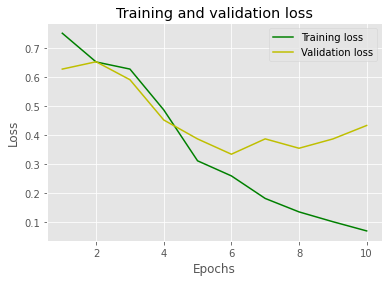

In [21]:
# plotar a curva de acurácia no treino e validação

plt.clf()
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


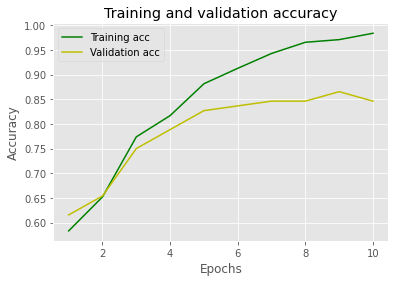

In [22]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'y', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Accuracy: 0.7906976744186046
F1_score: 0.8269230769230769


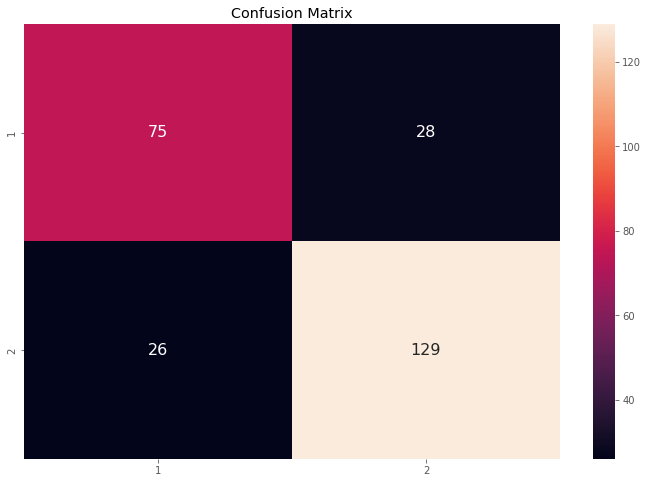

In [23]:
y_pred = model_lstm.predict(X_test)

F1 = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

print("Accuracy: {}".format(acc))
print("F1_score: {}".format(F1))

df_cm = pd.DataFrame(cm, [1,2], [1,2])
fig, axs = plt.subplots(1,1, figsize=(12,8))
sns.heatmap(df_cm, annot=True, ax=axs, annot_kws={"size": 16}, fmt="d") 
axs.set_title('Confusion Matrix')
plt.show()